# DDQN Car Racing - Notebook Complet

Ce notebook implémente un agent **DDQN (Double Deep Q-Network)** pour jouer à l'environnement CarRacing-v3 de Gymnasium.

## Pourquoi DDQN et pas DQN classique ?
- **Problème du DQN** : Surestimation systématique des Q-values (maximisation biais)
- **Solution DDQN** : Sépare la sélection et l'évaluation des actions avec 2 réseaux
- **Résultat** : Apprentissage plus stable, meilleure convergence, performances supérieures

## Structure du notebook:
1. **Imports et Configuration**
2. **Wrappers d'Environnement**
3. **Architecture du Réseau DDQN**
4. **Classe Agent DDQN**
5. **Fonctions Utilitaires**
6. **Entraînement**
7. **Évaluation**

## 1. Imports et Configuration

In [2]:
import os
import csv
import datetime
import matplotlib
import torch
import numpy as np
import matplotlib.pyplot as plt

import gymnasium as gym
import gymnasium.wrappers as gym_wrap

from tensordict import TensorDict
from torch import nn
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage
from typing import Union
from tqdm.notebook import tqdm  # Barre de progression pour notebooks

# Configuration pour les notebooks Jupyter
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# Vérifier la disponibilité de CUDA
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device utilisé: {device}")
print(f"Version de PyTorch: {torch.__version__}")
print(f"Version de Gymnasium: {gym.__version__}")

/Users/enzoberreur/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Device utilisé: cpu
Version de PyTorch: 2.1.2
Version de Gymnasium: 1.1.1


## 2. Wrapper d'Environnement - SkipFrame

Ce wrapper permet de sauter des frames pour accélérer l'entraînement.

In [3]:
class SkipFrame(gym.Wrapper):
    """
    Wrapper pour sauter des frames et accélérer l'entraînement.
    
    Répète la même action pendant N frames consécutives pour :
    - Réduire le nombre de décisions (gain de temps de calcul)
    - Éviter les mouvements trop saccadés
    
    Parameters:
        env (gymnasium.Env) : L'environnement Gymnasium à wrapper
        skip (int) : Nombre de frames à sauter (typiquement 4)
    """
    def __init__(self, env, skip):
        super().__init__(env)
        self._skip = skip

    def step(self, action):
        """Exécute l'action pendant N frames et cumule les récompenses."""
        total_reward = 0.0
        for _ in range(self._skip):
            state, reward, terminated, truncated, info = self.env.step(action)
            total_reward += reward
            if terminated:
                break
        return state, total_reward, terminated, truncated, info

## 3. Architecture du Réseau DDQN

Réseau de neurones convolutionnel pour approximer la fonction Q-value.

**Architecture inspirée de DeepMind (Nature 2015) :**
- Optimisée pour traiter des images 84x84 en niveaux de gris
- CNN pour extraction automatique des features visuelles
- Adaptée aux environnements Atari et similaires (dont CarRacing)

In [4]:
class DQN(nn.Module):
    """
    Réseau de neurones convolutionnel pour approximer la fonction Q-value (utilisé en DDQN).
    
    Architecture inspirée de DeepMind (Nature 2015) :
    - 2 couches convolutionnelles pour extraire les features visuelles
    - 2 couches fully-connected pour estimer les Q-values de chaque action
    
    Note : Ce réseau sera dupliqué en 2 copies pour l'algorithme DDQN :
    - updating_net : mis à jour à chaque batch
    - frozen_net : synchronisé périodiquement pour stabiliser l'apprentissage
    
    Parameters:
        in_dim (tuple) : Forme de l'état d'entrée (channels, hauteur, largeur)
        out_dim (int) : Nombre d'actions possibles (5 pour CarRacing-v3)
    """
    def __init__(self, in_dim: tuple, out_dim: int):
        super().__init__()
        cannel_n, height, width = in_dim
        if height != 84 or width != 84:
            error_text = f"Le modèle DDQN requiert des images 84x84. " \
                         f"Reçu : ({height}, {width})"
            raise ValueError(error_text)
        
        self.net = nn.Sequential(
            # Couche 1 : Détection de features grossières (lignes, bords)
            nn.Conv2d(in_channels=cannel_n, out_channels=16,
                      kernel_size=8, stride=4),
            nn.ReLU(),
            # Couche 2 : Features plus complexes (virages, route)
            nn.Conv2d(in_channels=16, out_channels=32,
                      kernel_size=4, stride=2),
            nn.ReLU(),
            # Aplatissement pour passer aux couches denses
            nn.Flatten(),
            # Couche dense : Combinaison des features
            nn.Linear(2592, 256),
            nn.ReLU(),
            # Sortie : Q-value pour chaque action
            nn.Linear(256, out_dim),
        )

    def forward(self, input):
        """Calcule les Q-values pour toutes les actions possibles."""
        return self.net(input)

## 4. Classe Agent DDQN

Implémentation complète de l'algorithme **Double Deep Q-Network**.

### Composants principaux :
- **Replay Buffer** : Stockage des transitions pour casser les corrélations temporelles
- **Epsilon-Greedy** : Balance exploration (actions aléatoires) / exploitation (meilleures actions)
- **Double Q-Learning** : Deux réseaux pour réduire l'overestimation des Q-values
- **Experience Replay** : Apprentissage par mini-batches échantillonnés aléatoirement

### Pourquoi ces choix ?
- **Replay Buffer (300k)** : Assez grand pour stocker des expériences variées sans surcharger la RAM
- **Double Q** : Crucial pour la stabilité sur des tâches continues comme CarRacing
- **Epsilon decay** : Décroissance lente pour bien explorer avant d'exploiter

In [5]:
class Agent:
    """
    Classe principale implémentant l'algorithme DDQN (Double Deep Q-Network).

    Parameters:
        state_space_shape (int) : Forme de l'espace d'état
        action_n (int) : Nombre d'actions possibles
        load_state (str) : 'train' pour continuer l'entraînement, 'eval' pour évaluation
        load_model (str) : Nom du modèle à charger
        double_q (bool) : Active le Double Q-Learning (RECOMMANDÉ : True)
        gamma (float) : Facteur de discount (0.95 = équilibre court/long terme)
        epsilon (float) : Taux d'exploration initial (1.0 = 100% aléatoire au début)
        epsilon_decay (float) : Décroissance d'epsilon (0.9999925 = lent, bien pour exploration)
        epsilon_min (float) : Exploration minimale conservée (0.05 = 5% d'actions aléatoires)
    """
    def __init__(
        self,
        state_space_shape: int,
        action_n: int,
        load_state: str = "",
        load_model: str = None,
        double_q: bool = False,
        gamma: float = 0.95,
        epsilon: float = 1,
        epsilon_decay: float = 0.9999925,
        epsilon_min: float = 0.05
    ):
        # ========== HYPERPARAMÈTRES DDQN ==========
        # Discount factor (gamma = 0.95)
        # → Balance récompenses immédiates vs futures
        # → 0.95 = bon équilibre pour tâches continues
        self.gamma = gamma
        
        # Epsilon-Greedy (exploration vs exploitation)
        # → epsilon = 1.0 : 100% exploration au début
        # → epsilon_decay = 0.9999925 : décroissance TRÈS lente (~200k steps pour atteindre 0.05)
        # → epsilon_min = 0.05 : conserve 5% d'exploration (évite les minima locaux)
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        
        # Configuration de l'environnement
        self.state_shape = state_space_shape
        self.action_n = action_n
        self.load_state = load_state
        self.double_q = double_q
        
        # Répertoires de sauvegarde
        self.save_dir = './training/saved_models/'
        self.log_dir = './training/logs/'
        
        # Device : GPU si disponible, sinon CPU
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        
        # ========== ARCHITECTURE DOUBLE Q-NETWORK ==========
        # Deux réseaux identiques pour l'algorithme DDQN :
        # 1. updating_net : mis à jour à chaque batch (apprentissage continu)
        # 2. frozen_net : copie gelée, synchronisée toutes les 5000 steps
        #    → Réduit l'overestimation des Q-values (problème majeur du DQN)
        #    → Stabilise l'apprentissage en fournissant des cibles fixes
        self.updating_net = DQN(self.state_shape, self.action_n).float()
        self.updating_net = self.updating_net.to(device=self.device)
        self.frozen_net = DQN(self.state_shape, self.action_n).float()
        self.frozen_net = self.frozen_net.to(device=self.device)
        
        # ========== OPTIMISATION ==========
        # Adam optimizer (lr=0.0002)
        # → Learning rate faible pour stabilité (RL est sensible aux grands changements)
        # → Adam adapte le learning rate par paramètre (meilleur que SGD pour RL)
        self.optimizer = torch.optim.Adam(self.updating_net.parameters(), lr=0.0002)
        
        # SmoothL1Loss (Huber Loss)
        # → Moins sensible aux outliers que MSE
        # → Quadratique près de 0, linéaire ailleurs
        # → Recommandé pour le DQN (papier original DeepMind)
        self.loss_fn = torch.nn.SmoothL1Loss()
        
        # ========== REPLAY BUFFER ==========
        # Capacité : 300,000 transitions
        # → Assez grand pour diversité sans surcharger la RAM
        # → LazyMemmapStorage : stockage sur disque efficace
        # → Permet de réutiliser les expériences passées (sample efficiency)
        self.buffer = TensorDictReplayBuffer(
                storage=LazyMemmapStorage(
                    300000,
                    device=torch.device("cpu")))
        
        # Compteurs
        self.act_taken = 0      # Nombre total d'actions effectuées
        self.n_updates = 0      # Nombre de mises à jour du réseau
        
        # Chargement d'un modèle existant si demandé
        if load_state:
            if load_model == None:
                raise ValueError(f"Spécifiez un nom de modèle à charger.")
            load_dir = self.save_dir
            self.load_model = load_model
            self.load(load_dir, load_model)
        

    def store(
        self, 
        state: Union[np.ndarray, torch.Tensor], 
        action: int, 
        reward: float, 
        new_state: Union[np.ndarray, torch.Tensor], 
        terminated: bool
    ):
        """
        Stocke une transition (s, a, r, s', done) dans le replay buffer.
        
        Le replay buffer permet d'apprendre de manière plus stable en :
        - Cassant les corrélations temporelles entre expériences successives
        - Réutilisant les expériences passées (sample efficiency)
        
        Parameters:
            state : État actuel de l'environnement
            action : Action prise par l'agent
            reward : Récompense reçue
            new_state : État suivant après l'action
            terminated : True si l'épisode est terminé
        """
        self.buffer.add(
            TensorDict(
                {
                    "state": torch.tensor(state),
                    "action": torch.tensor(action),
                    "reward": torch.tensor(reward),
                    "new_state": torch.tensor(new_state),
                    "terminated": torch.tensor(terminated)
                }, 
                batch_size=[]
            )
        )

    def get_samples(self, batch_size: int):
        """
        Échantillonne un batch de transitions du replay buffer.
        
        Parameters:
            batch_size : Nombre de transitions à échantillonner
            
        Returns:
            states : Batch d'états
            actions : Batch d'actions
            rewards : Batch de récompenses
            new_states : Batch d'états suivants
            terminateds : Batch de flags de terminaison
        """
        batch = self.buffer.sample(batch_size)
        states = batch.get('state').type(torch.FloatTensor).to(self.device)
        new_states = batch.get('new_state').type(torch.FloatTensor).to(self.device)
        actions = batch.get('action').squeeze().to(self.device)
        rewards = batch.get('reward').squeeze().to(self.device)
        terminateds = batch.get('terminated').squeeze().to(self.device)
        return states, actions, rewards, new_states, terminateds

    def take_action(self, state: Union[np.ndarray, torch.Tensor]):
        """
        Sélectionne une action selon la politique epsilon-greedy.
        
        Stratégie d'exploration/exploitation :
        - Avec probabilité epsilon : action aléatoire (exploration)
        - Avec probabilité (1-epsilon) : meilleure action selon le réseau (exploitation)
        
        Epsilon décroît au fil du temps pour favoriser progressivement l'exploitation.
        
        Parameters:
            state : État actuel de l'environnement
            
        Returns:
            action_idx : Index de l'action choisie (0 à 4 pour CarRacing)
        """
        # Exploration : action aléatoire
        if np.random.rand() < self.epsilon:
            action_idx = np.random.randint(self.action_n)
        # Exploitation : meilleure action selon le réseau
        else:
            state = torch.tensor(
                state,
                dtype=torch.float32,
                device=self.device
                ).unsqueeze(0)
            action_values = self.updating_net(state)
            action_idx = torch.argmax(action_values, axis=1).item()
        
        # Décroissance progressive d'epsilon (exploration → exploitation)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min
        
        self.act_taken += 1
        return action_idx

    def update_net(self, batch_size: int):
        """
        Met à jour le réseau Q via l'algorithme DDQN (Double Deep Q-Network).
        
        ### Différence DQN vs DDQN :
        
        **DQN classique (biais de maximisation) :**
        ```
        Q_target = r + γ * max[Q_frozen(s', a')]
        → Utilise le même réseau pour SÉLECTIONNER et ÉVALUER
        → Tend à SURESTIMER les Q-values
        ```
        
        **DDQN (notre implémentation) :**
        ```
        a* = argmax[Q_updating(s')]           # Sélection de l'action
        Q_target = r + γ * Q_frozen(s', a*)   # Évaluation avec l'autre réseau
        → RÉDUIT l'overestimation
        → Apprentissage PLUS STABLE
        ```
        
        Parameters:
            batch_size : Nombre de transitions (défaut: 32, bon compromis vitesse/stabilité)
            
        Returns:
            td_est : Q-values estimées pour le batch
            loss : Valeur de la loss calculée
        """
        self.n_updates += 1
        states, actions, rewards, \
            new_states, terminateds = self.get_samples(batch_size)
        
        # Q-values actuelles pour les actions prises
        action_values = self.updating_net(states)
        td_est = action_values[np.arange(batch_size), actions]
        
        # Calcul de la cible (target) avec l'algorithme DDQN
        if self.double_q:
            # ========== ALGORITHME DOUBLE DQN ==========
            # Étape 1 : Sélection de l'action avec updating_net (réseau en apprentissage)
            # Étape 2 : Évaluation de cette action avec frozen_net (réseau stable)
            # → Cette séparation réduit le biais de maximisation
            with torch.no_grad():
                next_actions = torch.argmax(self.updating_net(new_states), axis=1)
                tar_action_values = self.frozen_net(new_states)
            td_tar = rewards + (1 - terminateds.float()) \
                * self.gamma*tar_action_values[np.arange(batch_size), next_actions]
        else:
            # DQN classique (non recommandé, overestimation des Q-values)
            with torch.no_grad():
                tar_action_values = self.frozen_net(new_states)
            td_tar = rewards + (1 - terminateds.float()) * self.gamma*tar_action_values.max(1)[0]
        
        # Calcul de la loss et mise à jour des poids
        loss = self.loss_fn(td_est, td_tar)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        loss = loss.item()
        return td_est, loss

    def save(self, save_dir: str, save_name: str):
        """
        Sauvegarde le modèle et ses paramètres d'entraînement.
        
        Note importante : Le replay buffer n'est PAS sauvegardé car il utilise
        du memory-mapping (LazyMemmapStorage) qui ne peut pas être sérialisé.
        Cela n'affecte pas la reprise de l'entraînement : le buffer se remplira
        à nouveau progressivement.
        
        Parameters:
            save_dir : Répertoire de sauvegarde
            save_name : Préfixe du nom de fichier (le timestep sera ajouté)
        """
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save_path = save_dir + save_name + f"_{self.act_taken}.pt"
        torch.save(
            {
                'upd_model_state_dict': self.updating_net.state_dict(),
                'frz_model_state_dict': self.frozen_net.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                # Le replay buffer est exclu (impossible à sérialiser avec mmap)
                'action_number': self.act_taken,
                'epsilon': self.epsilon
            }, 
            save_path
        )
        print(f"Modèle sauvegardé : {save_path} (timestep {self.act_taken})")

    def load(self, load_dir: str, model_name: str):
        """
        Charge un modèle sauvegardé et ses paramètres.

        Parameters:
            load_dir : Répertoire contenant le modèle
            model_name : Nom du fichier du modèle sauvegardé
        """
        loaded_model = torch.load(load_dir+model_name)
        upd_net_param = loaded_model['upd_model_state_dict']
        frz_net_param = loaded_model['frz_model_state_dict']
        opt_param = loaded_model['optimizer_state_dict']
        self.updating_net.load_state_dict(upd_net_param)
        self.frozen_net.load_state_dict(frz_net_param)
        self.optimizer.load_state_dict(opt_param)
        
        if self.load_state == 'eval':
            self.updating_net.eval()
            self.frozen_net.eval()
            self.epsilon_min = 0
            self.epsilon = 0
        elif self.load_state == 'train':
            self.updating_net.train()
            self.frozen_net.train()
            self.act_taken = loaded_model['action_number']
            self.epsilon = loaded_model['epsilon']
        else:
            raise ValueError(f"État de chargement inconnu. Doit être 'eval' ou 'train'.")
        
    def write_log(
        self,
        date_list: list,
        time_list: list,
        reward_list: list,
        length_list: list,
        loss_list: list,
        epsilon_list: list,
        log_filename: str = 'default_log.csv'
    ):
        """
        Écrit les logs d'entraînement dans un fichier CSV.

        Parameters:
            date_list : Liste des dates pour chaque épisode
            time_list : Liste des heures pour chaque épisode
            reward_list : Liste des récompenses obtenues
            length_list : Liste des longueurs d'épisodes (nombre de steps)
            loss_list : Liste des losses enregistrées
            epsilon_list : Liste des valeurs d'epsilon (taux d'exploration)
            log_filename : Nom du fichier CSV de sortie
        """
        if not os.path.exists(self.log_dir):
            os.makedirs(self.log_dir)
        rows = [['date']+date_list,
                ['time']+time_list,
                ['reward']+reward_list,
                ['length']+length_list,
                ['loss']+loss_list,
                ['epsilon']+epsilon_list]
        with open(self.log_dir+log_filename, 'w') as csvfile:  
            csvwriter = csv.writer(csvfile)    
            csvwriter.writerows(rows)

## 5. Fonction Utilitaire - Visualisation des Récompenses

In [6]:
def plot_reward(episode_num: int, reward_list: list, n_steps: int):
    """
    Affiche la progression des récompenses au fil des épisodes.
    
    Visualise :
    - La courbe brute des récompenses par épisode
    - La moyenne mobile sur 50 épisodes (tendance lissée)
    - Les statistiques récentes (10 derniers épisodes)
    
    Parameters:
        episode_num : Numéro de l'épisode actuel
        reward_list : Liste de toutes les récompenses obtenues
        n_steps : Nombre total de timesteps effectués
    """
    plt.figure(1)
    rewards_tensor = torch.tensor(reward_list, dtype=torch.float)
    
    # Titre avec statistiques récentes si assez de données
    if len(rewards_tensor) >= 11:
        eval_reward = torch.clone(rewards_tensor[-10:])
        mean_eval_reward = round(torch.mean(eval_reward).item(), 2)
        std_eval_reward = round(torch.std(eval_reward).item(), 2)
        plt.clf()
        plt.title(f'Épisode #{episode_num} : {n_steps} steps, '
                  f'récompense {mean_eval_reward}±{std_eval_reward}')
    else:
        plt.clf()
        plt.title('Entraînement en cours...')
    
    plt.xlabel('Épisode')
    plt.ylabel('Récompense')
    plt.plot(rewards_tensor.numpy(), alpha=0.6, label='Récompense brute')
    
    # Moyenne mobile sur 50 épisodes pour visualiser la tendance
    if len(rewards_tensor) >= 50:
        reward_f = torch.clone(rewards_tensor[:50])
        means = rewards_tensor.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.ones(49)*torch.mean(reward_f), means))
        plt.plot(means.numpy(), linewidth=2, label='Moyenne mobile (50 ép.)')
        plt.legend()
    
    plt.pause(0.001)
    # Note : pas de clear_output() pour préserver la barre de progression tqdm

## 6. Entraînement DDQN - Nouveau Modèle

### 6.1 Configuration de l'Environnement CarRacing-v3

**Pipeline de prétraitement :**
1. `SkipFrame(4)` : Répète chaque action 4 fois → réduit les calculs
2. `GrayscaleObservation` : RGB → Grayscale → réduit de 3 à 1 canal
3. `ResizeObservation(84,84)` : Standardise la taille (requis par le CNN)
4. `FrameStackObservation(4)` : Empile 4 frames → capture le mouvement

**Résultat final :** État = (4, 84, 84) = 4 frames grayscale de 84x84 pixels

In [7]:
# Créer l'environnement CarRacing-v3 avec les wrappers
env = gym.make("CarRacing-v3", continuous=False)
env = SkipFrame(env, skip=4)
env = gym_wrap.GrayscaleObservation(env)
env = gym_wrap.ResizeObservation(env, shape=(84, 84))
env = gym_wrap.FrameStackObservation(env, stack_size=4)  # Correction: FrameStackObservation au lieu de FrameStack

state, info = env.reset()
action_n = env.action_space.n

print(f"Shape de l'état: {state.shape}")
print(f"Nombre d'actions: {action_n}")

Shape de l'état: (4, 84, 84)
Nombre d'actions: 5


### 6.2 Créer l'Agent DDQN

**Configuration recommandée :**
- `double_q=True` : Active l'algorithme DDQN (crucial pour la performance)
- Gamma, epsilon et leurs paramètres sont définis dans la classe Agent

In [8]:
# Créer un nouvel agent DDQN
driver = Agent(state.shape, action_n, double_q=True)

print(f"Agent DDQN créé")
print(f"Device: {driver.device}")
print(f"Algorithme: {'DDQN' if driver.double_q else 'DQN'}")
print(f"Epsilon initial: {driver.epsilon}")
print(f"Gamma: {driver.gamma}")
print(f"Learning rate: 0.0002")
print(f"Buffer size: 300,000")

Agent DDQN créé
Device: cpu
Algorithme: DDQN
Epsilon initial: 1
Gamma: 0.95
Learning rate: 0.0002
Buffer size: 300,000


### 6.3 Boucle d'Entraînement Principale (Avec Barre de Progression)


### 6.4 Guide d'Ajustement des Hyperparamètres DDQN

#### Hyperparamètres actuels et justification :

| Paramètre | Valeur | Justification |
|-----------|--------|---------------|
| **gamma** | 0.95 | Bon équilibre court/long terme pour CarRacing |
| **epsilon_start** | 1.0 | 100% exploration au début (essentiel) |
| **epsilon_decay** | 0.9999925 | Décroissance lente (~200k steps) pour bien explorer |
| **epsilon_min** | 0.05 | Garde 5% d'exploration (évite minima locaux) |
| **learning_rate** | 0.0002 | Faible = stable (RL sensible aux gros changements) |
| **batch_size** | 32 | Compromis vitesse/stabilité |
| **buffer_size** | 300,000 | Grand = plus de diversité, bon pour tâches complexes |
| **when2learn** | 4 | Apprend souvent = convergence rapide |
| **when2sync** | 5000 | Sync fréquente = stabilité (crucial pour DDQN) |
| **when2save** | 100,000 | Sauvegarde régulière sans ralentir |

#### En cas de problème :

| Symptôme | Paramètre à ajuster | Nouvelle valeur |
|----------|---------------------|-----------------|
| Récompenses stagnent | `learning_rate` | 0.0001 ou 0.0005 |
| Loss explose | `learning_rate` | 0.0001 |
| Pas assez d'exploration | `epsilon_decay` | 0.999995 (plus lent) |
| Trop d'exploration tard | `epsilon_min` | 0.01 |
| Instabilité sévère | `when2sync` | 2500 (sync plus souvent) |
| Apprentissage trop lent | `when2learn` | 2 |
| Mémoire insuffisante | `batch_size` | 16 |


In [10]:
# Paramètres d'entraînement
batch_n = 32
play_n_episodes = 1500

when2learn = 4
when2sync = 5000
when2save = 100000
when2log = 10

# Métriques de suivi
episode_epsilon_list = []
episode_reward_list = []
episode_length_list = []
episode_loss_list = []
episode_date_list = []
episode_time_list = []
episode = 0
timestep_n = 0

print("Début de l'entraînement DDQN")
print(f"Algorithme: DDQN")
print(f"Objectif: {play_n_episodes} épisodes (~{play_n_episodes*250:,} timesteps)")
print(f"Device: {driver.device}")
print(f"Batch size: {batch_n}")
print(f"Sync interval: {when2sync} steps")
print("="*60)

# Barre de progression
progress_bar = tqdm(range(1, play_n_episodes + 1), desc="Entraînement", unit="épisode")

for episode in progress_bar:
    episode_reward = 0
    episode_length = 0
    updating = True
    loss_list = []
    episode_epsilon_list.append(driver.epsilon)

    while updating:
        timestep_n += 1
        episode_length += 1
        
        action = driver.take_action(state)
        new_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        driver.store(state, action, reward, new_state, terminated)
        state = new_state
        updating = not (terminated or truncated)

        # Synchronisation des réseaux (DDQN)
        if timestep_n % when2sync == 0:
            upd_net_param = driver.updating_net.state_dict()
            driver.frozen_net.load_state_dict(upd_net_param)
            
        # Sauvegarde périodique
        if timestep_n % when2save == 0:
            driver.save(driver.save_dir, 'DDQN')
            
        # Apprentissage
        if timestep_n % when2learn == 0:
            q, loss = driver.update_net(batch_n)
            loss_list.append(loss)

    # Reset environnement
    state, info = env.reset()
    
    # Enregistrement des métriques
    episode_reward_list.append(episode_reward)
    episode_length_list.append(episode_length)
    episode_loss_list.append(np.mean(loss_list) if loss_list else 0)
    now_time = datetime.datetime.now()
    episode_date_list.append(now_time.date().strftime('%Y-%m-%d'))
    episode_time_list.append(now_time.time().strftime('%H:%M:%S'))
    
    # Mise à jour barre de progression
    if len(episode_reward_list) >= 10:
        recent_rewards = episode_reward_list[-10:]
        avg_reward = np.mean(recent_rewards)
        progress_bar.set_postfix({
            'Reward': f'{episode_reward:.1f}',
            'Avg(10)': f'{avg_reward:.1f}',
            'Loss': f'{np.mean(loss_list):.3f}' if loss_list else 'N/A',
            'ε': f'{driver.epsilon:.3f}',
            'Steps': timestep_n
        })
    else:
        progress_bar.set_postfix({
            'Reward': f'{episode_reward:.1f}',
            'ε': f'{driver.epsilon:.3f}'
        })
    
    # Écriture logs
    if episode % when2log == 0:
        driver.write_log(
            episode_date_list,
            episode_time_list,
            episode_reward_list,
            episode_length_list,
            episode_loss_list,
            episode_epsilon_list,
            log_filename='DDQN_log_v3.csv'
        )

# Fermeture de la barre de progression
progress_bar.close()

# ========== RAPPORT FINAL D'ENTRAÎNEMENT ==========
print("\nRAPPORT FINAL D'ENTRAÎNEMENT")
print("="*60)

rewards_tensor = torch.tensor(episode_reward_list, dtype=torch.float)

# Statistiques (100 derniers épisodes)
if len(episode_reward_list) >= 100:
    eval_reward = torch.clone(rewards_tensor[-100:])
    eval_window = 100
else:
    eval_reward = rewards_tensor
    eval_window = len(episode_reward_list)

mean_eval_reward = round(torch.mean(eval_reward).item(), 2)
std_eval_reward = round(torch.std(eval_reward).item(), 2)

lengths_tensor = torch.tensor(episode_length_list, dtype=torch.float)
eval_length = torch.clone(lengths_tensor[-eval_window:])
mean_eval_length = round(torch.mean(eval_length).item(), 2)
std_eval_length = round(torch.std(eval_length).item(), 2)

print(f"Épisodes complétés : {episode}")
print(f"Total timesteps : {timestep_n}")
print(f"Mises à jour du réseau : {driver.n_updates}")
print(f"\nPerformance (derniers {eval_window} épisodes):")
print(f"  Récompense : {mean_eval_reward} ± {std_eval_reward}")
print(f"  Longueur épisode : {mean_eval_length} ± {std_eval_length}")
print(f"\nExploration:")
print(f"Epsilon final : {driver.epsilon:.4f}")

# Évaluation
print("\nÉVALUATION DE L'APPRENTISSAGE")
print(f"{'='*60}")

if mean_eval_reward > 700:
    print("Excellent - Modèle maîtrise la tâche")
    print("  Peut être utilisé en production")
elif mean_eval_reward > 400:
    print("Bien - Apprentissage réussi")
    print("  Continuez l'entraînement pour optimiser")
elif mean_eval_reward > 0:
    print("Moyen - Progrès en cours")
    print("  Continuez l'entraînement (500-1000 épisodes)")
elif mean_eval_reward > -200:
    print("Faible - Apprentissage limité")
    print("  Vérifiez les hyperparamètres")
else:
    print("Problème - Pas d'apprentissage efficace")
    print("  Ajustez epsilon_decay, learning_rate ou when2sync")

print(f"{'='*60}\n")

# Sauvegarde finale
driver.save(driver.save_dir, 'DDQN')
driver.write_log(
    episode_date_list,
    episode_time_list,
    episode_reward_list,
    episode_length_list,
    episode_loss_list,
    episode_epsilon_list,
    log_filename='DDQN_log_v3.csv'
)

# Graphique de progression
print("Génération du graphique de progression...")

plt.figure(figsize=(12, 6))

# Courbe récompenses
plt.plot(rewards_tensor.numpy(), label='Récompense par épisode', alpha=0.6, color='steelblue')

# Moyenne mobile (50 épisodes)
if len(rewards_tensor) >= 50:
    reward_f = torch.clone(rewards_tensor[:50])
    means = rewards_tensor.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.ones(49)*torch.mean(reward_f), means))
    plt.plot(means.numpy(), label='Moyenne mobile (50 épisodes)', linewidth=2, color='coral')

plt.xlabel('Épisode')
plt.ylabel('Récompense')
plt.title(f'Progression de l\'entraînement DDQN - {len(episode_reward_list)} épisodes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

env.close()
plt.ioff()

print("\nEntraînement terminé")

Début de l'entraînement DDQN
Algorithme: DDQN
Objectif: 1500 épisodes (~375,000 timesteps)
Device: cpu
Batch size: 32
Sync interval: 5000 steps


Entraînement:   0%|          | 0/1500 [00:00<?, ?épisode/s]

KeyboardInterrupt: 

## 7. Continuer l'Entraînement d'un Modèle DDQN Sauvegardé

### 7.1 Charger un Modèle Existant

**Important :** Le replay buffer n'est pas sauvegardé (limitation technique mmap).
Il se remplira progressivement lors de la reprise de l'entraînement.

In [9]:
# Créer l'environnement
env = gym.make("CarRacing-v3", continuous=False)
env = SkipFrame(env, skip=4)
env = gym_wrap.GrayscaleObservation(env)
env = gym_wrap.ResizeObservation(env, shape=(84, 84))
env = gym_wrap.FrameStackObservation(env, stack_size=4)
state, info = env.reset()
action_n = env.action_space.n

# Charger le modèle pour continuer l'entraînement
driver = Agent(
    state.shape,
    action_n,
    load_state='train',           # Mode 'train'
    load_model='DDQN_373469.pt',  # Modifier selon votre fichier
    double_q=True
)

print(f"Modèle chargé")
print(f"Epsilon: {driver.epsilon}")
print(f"Actions prises: {driver.act_taken}")
print(f"Algorithme: {'DDQN' if driver.double_q else 'DQN'}")

Modèle chargé
Epsilon: 0.0607475817652895
Actions prises: 373469
Algorithme: DDQN


### 7.2 Continuer l'Entraînement

🔄 Reprise de l'entraînement DDQN...
Epsilon initial: 0.0607475817652895
Actions déjà prises: 373469
Épisodes déjà joués: 1500
Objectif: +500 épisodes supplémentaires


Continuation:   0%|          | 0/500 [00:00<?, ?épisode/s]

Modèle sauvegardé : ./training/saved_models/DDQN_400000.pt (timestep 400000)

📊 RAPPORT FINAL DE LA CONTINUATION
Épisodes complétés : 2000
Total timesteps : 495213
Mises à jour du réseau : 30436

Performance (derniers 100 épisodes):
  Récompense : 869.59 ± 59.53
  Longueur épisode : 237.53 ± 19.75

Exploration:
  Epsilon final : 0.0500

🎯 ÉVALUATION DE L'APPRENTISSAGE
🏆 EXCELLENT ! Le modèle maîtrise bien la tâche.

Modèle sauvegardé : ./training/saved_models/DDQN_495213.pt (timestep 495213)
📈 Génération du graphique de progression...

📊 RAPPORT FINAL DE LA CONTINUATION
Épisodes complétés : 2000
Total timesteps : 495213
Mises à jour du réseau : 30436

Performance (derniers 100 épisodes):
  Récompense : 869.59 ± 59.53
  Longueur épisode : 237.53 ± 19.75

Exploration:
  Epsilon final : 0.0500

🎯 ÉVALUATION DE L'APPRENTISSAGE
🏆 EXCELLENT ! Le modèle maîtrise bien la tâche.

Modèle sauvegardé : ./training/saved_models/DDQN_495213.pt (timestep 495213)
📈 Génération du graphique de progressio

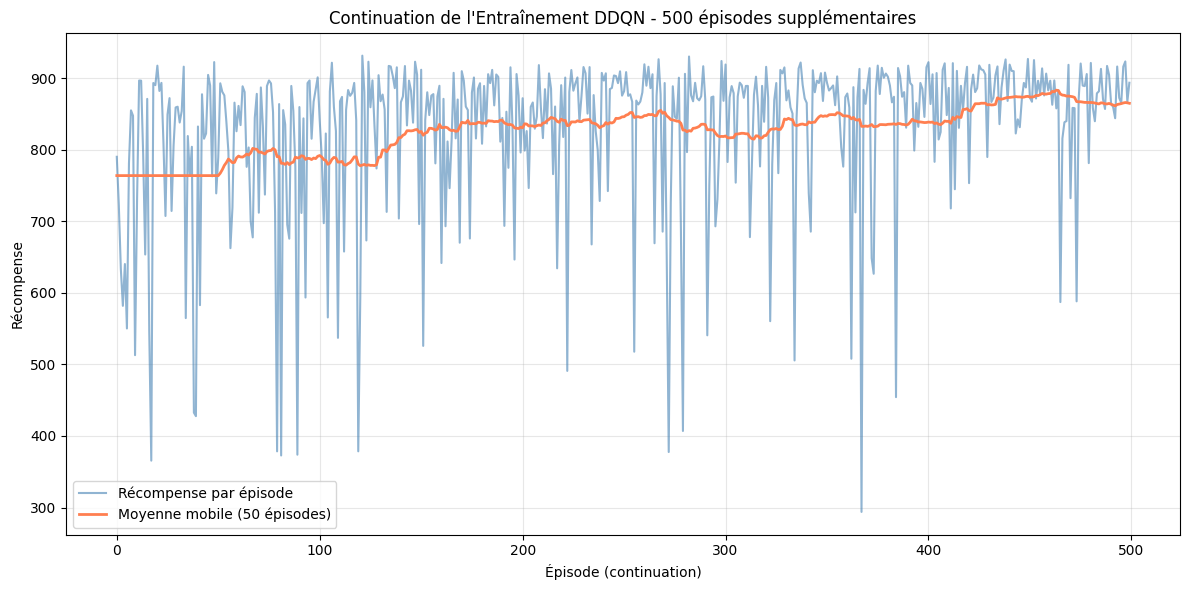


✅ Continuation de l'entraînement terminée!


In [ ]:
# Paramètres pour la continuation
batch_n = 32
actions_taken = driver.act_taken
play_more_episodes = 500  # Nombre d'épisodes supplémentaires
episodes_played = 1500    # Nombre d'épisodes déjà joués (à ajuster selon ton entraînement)
timestep_n = actions_taken
episode_start = episodes_played

episode_epsilon_list = []
episode_reward_list = []
episode_length_list = []
episode_loss_list = []
episode_date_list = []
episode_time_list = []

when2learn = 4
when2sync = 5000
when2save = 100000
when2log = 10

print(f'Reprise de l\'entraînement DDQN')
print(f'Epsilon initial: {driver.epsilon}')
print(f'Actions prises: {actions_taken}')
print(f'Épisodes joués: {episodes_played}')
print(f'Objectif: +{play_more_episodes} épisodes')
print("="*60)

# Barre de progression
progress_bar = tqdm(range(1, play_more_episodes + 1), desc="Continuation", unit="épisode")

for episode_idx in progress_bar:
    episode = episode_start + episode_idx
    episode_reward = 0
    episode_length = 0
    updating = True
    loss_list = []
    episode_epsilon_list.append(driver.epsilon)

    while updating:
        timestep_n += 1
        episode_length += 1
        
        action = driver.take_action(state)
        new_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        driver.store(state, action, reward, new_state, terminated)
        state = new_state
        updating = not (terminated or truncated)

        # Synchronisation des réseaux (DDQN)
        if timestep_n % when2sync == 0:
            upd_net_param = driver.updating_net.state_dict()
            driver.frozen_net.load_state_dict(upd_net_param)
            
        # Sauvegarde périodique
        if timestep_n % when2save == 0:
            driver.save(driver.save_dir, 'DDQN')
            
        # Apprentissage
        if timestep_n % when2learn == 0:
            q, loss = driver.update_net(batch_n)
            loss_list.append(loss)

    # Reset environnement
    state, info = env.reset()
    
    # Enregistrement des métriques
    episode_reward_list.append(episode_reward)
    episode_length_list.append(episode_length)
    episode_loss_list.append(np.mean(loss_list) if loss_list else 0)
    now_time = datetime.datetime.now()
    episode_date_list.append(now_time.date().strftime('%Y-%m-%d'))
    episode_time_list.append(now_time.time().strftime('%H:%M:%S'))
    
    # Mise à jour barre de progression
    if len(episode_reward_list) >= 10:
        recent_rewards = episode_reward_list[-10:]
        avg_reward = np.mean(recent_rewards)
        progress_bar.set_postfix({
            'Reward': f'{episode_reward:.1f}',
            'Avg(10)': f'{avg_reward:.1f}',
            'Loss': f'{np.mean(loss_list):.3f}' if loss_list else 'N/A',
            'ε': f'{driver.epsilon:.3f}',
            'Steps': timestep_n
        })
    else:
        progress_bar.set_postfix({
            'Reward': f'{episode_reward:.1f}',
            'ε': f'{driver.epsilon:.3f}'
        })

    # Écriture périodique des logs
    if episode_idx % when2log == 0:
        driver.write_log(
            episode_date_list,
            episode_time_list,
            episode_reward_list,
            episode_length_list,
            episode_loss_list,
            episode_epsilon_list,
            log_filename='DDQN_log_continued_v3.csv'
        )

# Fermeture barre de progression
progress_bar.close()

# Rapport final
print("\nRAPPORT FINAL DE LA CONTINUATION")
print("="*60)

rewards_tensor = torch.tensor(episode_reward_list, dtype=torch.float)

if len(episode_reward_list) >= 100:
    eval_reward = torch.clone(rewards_tensor[-100:])
    eval_window = 100
else:
    eval_reward = rewards_tensor
    eval_window = len(episode_reward_list)

mean_eval_reward = round(torch.mean(eval_reward).item(), 2)
std_eval_reward = round(torch.std(eval_reward).item(), 2)

lengths_tensor = torch.tensor(episode_length_list, dtype=torch.float)
eval_length = torch.clone(lengths_tensor[-eval_window:])
mean_eval_length = round(torch.mean(eval_length).item(), 2)
std_eval_length = round(torch.std(eval_length).item(), 2)

print(f"Épisodes complétés : {episode}")
print(f"Total timesteps : {timestep_n}")
print(f"Mises à jour du réseau : {driver.n_updates}")
print(f"\nPerformance (derniers {eval_window} épisodes):")
print(f"  Récompense : {mean_eval_reward} ± {std_eval_reward}")
print(f"  Longueur épisode : {mean_eval_length} ± {std_eval_length}")
print(f"\nExploration:")
print(f"Epsilon final : {driver.epsilon:.4f}")

# Évaluation
print("\nÉVALUATION DE L'APPRENTISSAGE")
print(f"{'='*60}")

if mean_eval_reward > 700:
    print("Excellent - Modèle maîtrise la tâche")
elif mean_eval_reward > 400:
    print("Bien - Apprentissage réussi")
elif mean_eval_reward > 0:
    print("Moyen - Progrès en cours")
else:
    print("Faible - Nécessite plus d'entraînement")

print(f"{'='*60}\n")

# Sauvegarde finale
driver.save(driver.save_dir, 'DDQN')
driver.write_log(
    episode_date_list,
    episode_time_list,
    episode_reward_list,
    episode_length_list,
    episode_loss_list,
    episode_epsilon_list,
    log_filename='DDQN_log_continued_v3.csv'
)

# Graphique de progression
print("Génération du graphique de progression...")

plt.figure(figsize=(12, 6))
plt.plot(rewards_tensor.numpy(), label='Récompense par épisode', alpha=0.6, color='steelblue')

if len(rewards_tensor) >= 50:
    reward_f = torch.clone(rewards_tensor[:50])
    means = rewards_tensor.unfold(0, 50, 1).mean(1).view(-1)
    means = torch.cat((torch.ones(49)*torch.mean(reward_f), means))
    plt.plot(means.numpy(), label='Moyenne mobile (50 épisodes)', linewidth=2, color='coral')

plt.xlabel('Épisode (continuation)')
plt.ylabel('Récompense')
plt.title(f'Continuation de l\'Entraînement DDQN - {len(episode_reward_list)} épisodes supplémentaires')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

env.close()
plt.ioff()

print("\nContinuation de l'entraînement terminée")

## 7.4 Visualiser les Logs d'Entraînement (Avec Graphiques)

Cette section permet de charger et visualiser les logs de n'importe quel entraînement passé pour analyser la progression du modèle. Vous pouvez utiliser le fichier fusionné `DDQN_log_merged.csv` pour voir l'ensemble de l'entraînement.

## 7.3 Fusionner les Logs d'Entraînement

Si vous avez plusieurs fichiers CSV de logs (par exemple un entraînement initial et une continuation), cette cellule permet de les fusionner en un seul fichier consolidé.

In [10]:
import pandas as pd
import glob

# Configuration
log_files = [
    'training/logs/DDQN_log_v3.csv',
    'training/logs/DDQN_log_continued_v3.csv'
]

print("Fichiers à fusionner:")
for i, file in enumerate(log_files, 1):
    if os.path.exists(file):
        size = os.path.getsize(file) / 1024
        print(f"  {i}. {file} ({size:.1f} KB)")
    else:
        print(f"  {i}. {file} (FICHIER NON TROUVÉ)")

print("\nFusion en cours...")

# Chargement et concaténation
all_data = []
total_episodes = 0

for file in log_files:
    if os.path.exists(file):
        df = pd.read_csv(file, header=None)
        
        # Le CSV a le format: première colonne = noms des métriques, colonnes suivantes = épisodes
        # On renumérote les colonnes en continuité
        if total_episodes == 0:
            # Premier fichier: garder la première colonne (noms), renommer les autres
            df.columns = [df.columns[0]] + [str(i) for i in range(total_episodes, total_episodes + len(df.columns) - 1)]
        else:
            # Fichiers suivants: ignorer la première colonne (noms déjà présents), garder seulement les données
            df = df.iloc[:, 1:]  # Supprimer la première colonne
            df.columns = [str(i) for i in range(total_episodes, total_episodes + len(df.columns))]
        
        all_data.append(df)
        episodes_in_file = len(df.columns) - (1 if total_episodes == 0 else 0)
        total_episodes += episodes_in_file
        print(f"  {file}: {episodes_in_file} épisodes")

# Concaténation
if all_data:
    # Concaténer horizontalement
    merged_df = pd.concat(all_data, axis=1)
    output_file = 'training/logs/DDQN_log_merged.csv'
    merged_df.to_csv(output_file, index=False, header=False)
    
    print(f"\nFusion réussie:")
    print(f"  Total: {total_episodes} épisodes")
    print(f"  Fichier: {output_file}")
    print(f"  Taille: {os.path.getsize(output_file) / 1024:.1f} KB")
    
    # Statistiques globales
    # Charger le fichier fusionné pour analyse
    df_merged = pd.read_csv(output_file, header=None)
    df_t = df_merged.T
    df_t.columns = df_t.iloc[0]
    df_t = df_t.drop(df_t.index[0])
    df_t = df_t.reset_index(drop=True)
    df_t = df_t.apply(pd.to_numeric, errors='coerce')
    
    print(f"\nStatistiques globales:")
    print(f"  Reward moyen:  {df_t['reward'].mean():.2f} ± {df_t['reward'].std():.2f}")
    print(f"  Reward max:    {df_t['reward'].max():.2f}")
    print(f"  Loss moyenne:  {df_t['loss'].mean():.4f}")
    print(f"  Epsilon final: {df_t['epsilon'].iloc[-1]:.4f}")
else:
    print("Aucun fichier valide trouvé.")

Fichiers à fusionner:
  1. training/logs/DDQN_log_v3.csv (118.8 KB)
  2. training/logs/DDQN_log_continued_v3.csv (33.7 KB)

Fusion en cours...
  training/logs/DDQN_log_v3.csv: 1500 épisodes
  training/logs/DDQN_log_continued_v3.csv: 500 épisodes

Fusion réussie:
  Total: 2000 épisodes
  Fichier: training/logs/DDQN_log_merged.csv
  Taille: 152.4 KB

Statistiques globales:
  Reward moyen:  476.50 ± 344.73
  Reward max:    931.30
  Loss moyenne:  0.7173
  Epsilon final: 0.0500


In [11]:
import pandas as pd
import glob

# Liste des fichiers disponibles
print("MODÈLES SAUVEGARDÉS:")
print("-" * 70)
model_files = glob.glob('./training/saved_models/*.pt')
if model_files:
    for i, model in enumerate(sorted(model_files), 1):
        model_name = model.split('/')[-1]
        file_size = os.path.getsize(model) / (1024*1024)
        print(f"{i}. {model_name:<30} ({file_size:.2f} MB)")
else:
    print("Aucun modèle trouvé.")

print("\nFICHIERS DE LOGS:")
print("-" * 70)
log_files = glob.glob('./training/logs/*.csv')
if log_files:
    for i, log in enumerate(sorted(log_files), 1):
        log_name = log.split('/')[-1]
        print(f"{i}. {log_name}")
else:
    print("Aucun log trouvé.")

print("-" * 70)

MODÈLES SAUVEGARDÉS:
----------------------------------------------------------------------
1. DDQN_100000.pt                 (10.35 MB)
2. DDQN_200000.pt                 (10.35 MB)
3. DDQN_300000.pt                 (10.35 MB)
4. DDQN_373469.pt                 (10.35 MB)
5. DDQN_400000.pt                 (10.35 MB)
6. DDQN_495213.pt                 (10.35 MB)

FICHIERS DE LOGS:
----------------------------------------------------------------------
1. DDQN_log_continued_v3.csv
2. DDQN_log_merged.csv
3. DDQN_log_v3.csv
----------------------------------------------------------------------


In [13]:
# Charger logs
log_filename = 'DDQN_log_merged.csv'

try:
    log_path = f'./training/logs/{log_filename}'
    df = pd.read_csv(log_path, header=None)
    
    # Transposer le CSV
    df_T = df.T
    df_T.columns = df_T.iloc[0]
    df_T = df_T.drop(df_T.index[0])
    df_T = df_T.reset_index(drop=True)
    
    # Convertir en nombres
    df_T['reward'] = pd.to_numeric(df_T['reward'])
    df_T['length'] = pd.to_numeric(df_T['length'])
    df_T['loss'] = pd.to_numeric(df_T['loss'])
    df_T['epsilon'] = pd.to_numeric(df_T['epsilon'])
    
    n_episodes = len(df_T)
    
    print(f"Logs chargés: {log_filename}")
    print(f"Nombre d'épisodes: {n_episodes}")
    print(f"\n{'='*70}")
    print("STATISTIQUES GLOBALES")
    print(f"{'='*70}")
    print(f"Récompense moyenne : {df_T['reward'].mean():.2f}")
    print(f"Récompense max     : {df_T['reward'].max():.2f}")
    print(f"Récompense min     : {df_T['reward'].min():.2f}")
    print(f"Longueur moyenne   : {df_T['length'].mean():.0f} steps")
    print(f"Loss moyenne       : {df_T['loss'].mean():.4f}")
    print(f"Epsilon final      : {df_T['epsilon'].iloc[-1]:.4f}")
    
    # Statistiques (100 derniers épisodes)
    if n_episodes >= 100:
        last_100_rewards = df_T['reward'].tail(100)
        print(f"\n{'='*70}")
        print("PERFORMANCE RÉCENTE (100 derniers épisodes)")
        print(f"{'='*70}")
        print(f"Récompense moyenne : {last_100_rewards.mean():.2f} ± {last_100_rewards.std():.2f}")
        print(f"Récompense max     : {last_100_rewards.max():.2f}")
        print(f"Récompense min     : {last_100_rewards.min():.2f}")
        
        # Évaluation
        mean_reward = last_100_rewards.mean()
        print(f"\nÉVALUATION:")
        if mean_reward > 700:
            print("  Excellent - Modèle maîtrise la tâche")
        elif mean_reward > 400:
            print("  Bien - Apprentissage réussi")
        elif mean_reward > 0:
            print("  Moyen - Progression en cours")
        else:
            print("  Faible - Nécessite plus d'entraînement")
    
    print(f"{'='*70}\n")
    
except FileNotFoundError:
    print(f"Fichier non trouvé: {log_path}")
    print("Vérifiez le nom du fichier.")
except Exception as e:
    print(f"Erreur: {str(e)}")

Logs chargés: DDQN_log_merged.csv
Nombre d'épisodes: 2000

STATISTIQUES GLOBALES
Récompense moyenne : 476.50
Récompense max     : 931.30
Récompense min     : -162.51
Longueur moyenne   : 248 steps
Loss moyenne       : 0.7173
Epsilon final      : 0.0500

PERFORMANCE RÉCENTE (100 derniers épisodes)
Récompense moyenne : 869.59 ± 59.53
Récompense max     : 926.70
Récompense min     : 587.07

ÉVALUATION:
  Excellent - Modèle maîtrise la tâche



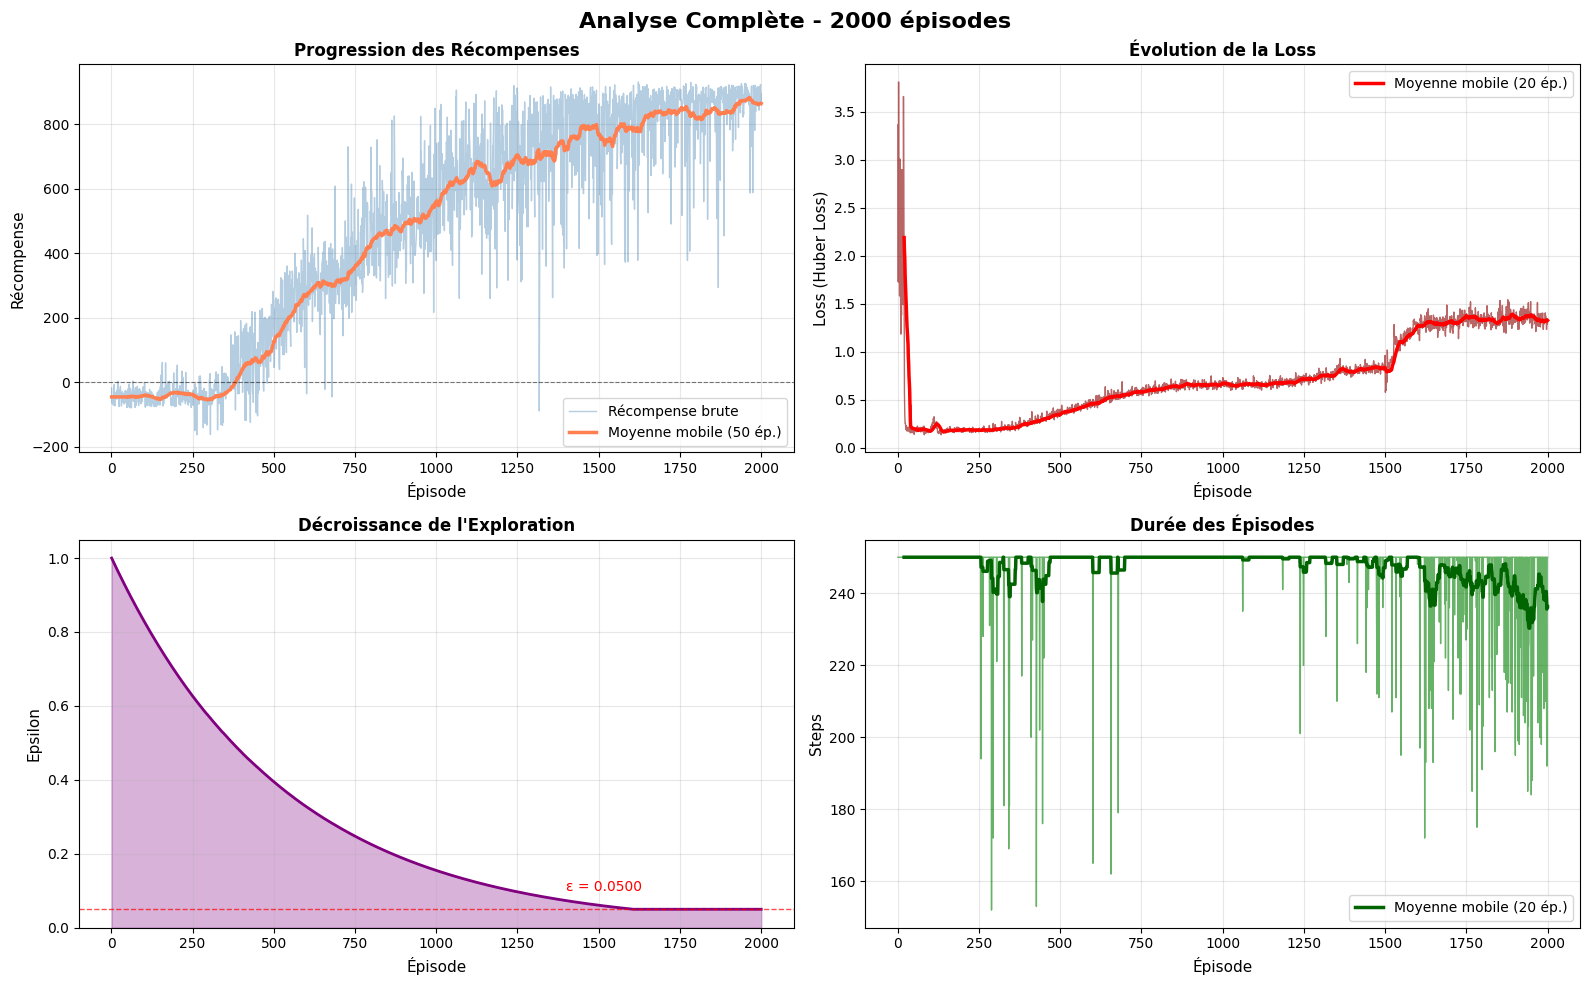

Dashboard généré.


In [14]:
# Dashboard (4 graphiques)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle(f'Analyse Complète - {n_episodes} épisodes', fontsize=16, fontweight='bold')

episodes_range = range(1, len(df_T) + 1)

# Graphique 1: Récompenses
ax1 = axes[0, 0]
ax1.plot(episodes_range, df_T['reward'], alpha=0.4, color='steelblue', 
         label='Récompense brute', linewidth=1)

if n_episodes >= 50:
    window = 50
    rewards_tensor = torch.tensor(df_T['reward'].values, dtype=torch.float)
    reward_f = torch.clone(rewards_tensor[:window])
    means = rewards_tensor.unfold(0, window, 1).mean(1).view(-1)
    means = torch.cat((torch.ones(window-1)*torch.mean(reward_f), means))
    ax1.plot(episodes_range, means.numpy(), linewidth=2.5, color='coral', 
             label=f'Moyenne mobile ({window} ép.)')

ax1.set_xlabel('Épisode', fontsize=11)
ax1.set_ylabel('Récompense', fontsize=11)
ax1.set_title('Progression des Récompenses', fontsize=12, fontweight='bold')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

# Graphique 2: Loss
ax2 = axes[0, 1]
ax2.plot(episodes_range, df_T['loss'], color='darkred', linewidth=1, alpha=0.6)

if n_episodes >= 20:
    loss_smooth = df_T['loss'].rolling(window=20).mean()
    ax2.plot(episodes_range, loss_smooth, color='red', linewidth=2.5, 
             label='Moyenne mobile (20 ép.)')
    ax2.legend()

ax2.set_xlabel('Épisode', fontsize=11)
ax2.set_ylabel('Loss (Huber Loss)', fontsize=11)
ax2.set_title('Évolution de la Loss', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Graphique 3: Epsilon
ax3 = axes[1, 0]
ax3.plot(episodes_range, df_T['epsilon'], color='purple', linewidth=2)
ax3.fill_between(episodes_range, df_T['epsilon'], alpha=0.3, color='purple')
ax3.set_xlabel('Épisode', fontsize=11)
ax3.set_ylabel('Epsilon', fontsize=11)
ax3.set_title('Décroissance de l\'Exploration', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.set_ylim([0, 1.05])

epsilon_end = df_T['epsilon'].iloc[-1]
ax3.axhline(y=epsilon_end, color='red', linestyle='--', linewidth=1, alpha=0.7)
ax3.text(len(df_T)*0.7, epsilon_end + 0.05, f'ε = {epsilon_end:.4f}', 
         fontsize=10, color='red')

# Graphique 4: Longueur des épisodes
ax4 = axes[1, 1]
ax4.plot(episodes_range, df_T['length'], color='green', linewidth=1, alpha=0.6)

if n_episodes >= 20:
    length_smooth = df_T['length'].rolling(window=20).mean()
    ax4.plot(episodes_range, length_smooth, color='darkgreen', linewidth=2.5, 
             label='Moyenne mobile (20 ép.)')
    ax4.legend()

ax4.set_xlabel('Épisode', fontsize=11)
ax4.set_ylabel('Steps', fontsize=11)
ax4.set_title('Durée des Épisodes', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Dashboard généré.")

ANALYSE PAR PHASE (500 épisodes/phase)
Phase      Épisodes             Récompense Moy.      Progression
Phase 1        1-500          -6.7 ± 77.9     —
Phase 2      501-1000        388.6 ± 148.6    +395.3
Phase 3     1001-1500        694.3 ± 146.8    +305.6
Phase 4     1501-2000        829.8 ± 109.9    +135.6

Amélioration totale: +836.5
Évaluation: Excellent progrès


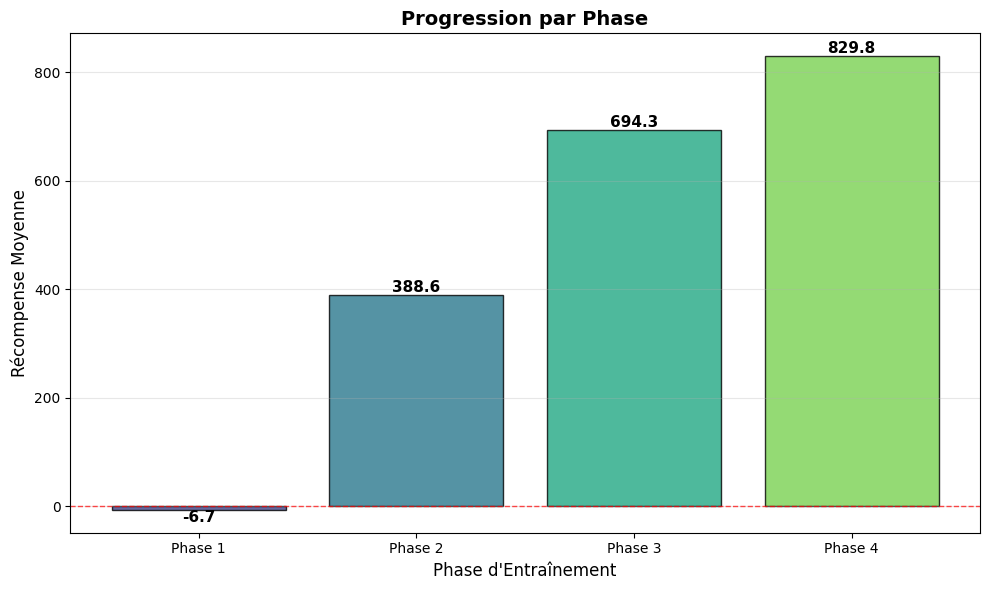

In [15]:
# Analyse par phases
n_phases = 4
phase_size = n_episodes // n_phases

print(f"ANALYSE PAR PHASE ({phase_size} épisodes/phase)")
print(f"{'='*70}")
print(f"{'Phase':<10} {'Épisodes':<20} {'Récompense Moy.':<20} {'Progression'}")
print(f"{'='*70}")

phase_rewards = []
for i in range(n_phases):
    start_idx = i * phase_size
    end_idx = (i + 1) * phase_size if i < n_phases - 1 else n_episodes
    
    phase_data = df_T.iloc[start_idx:end_idx]
    mean_reward = phase_data['reward'].mean()
    std_reward = phase_data['reward'].std()
    phase_rewards.append(mean_reward)
    
    if i > 0:
        progression = mean_reward - phase_rewards[i-1]
        prog_text = f"{progression:+.1f}"
    else:
        prog_text = "—"
    
    print(f"Phase {i+1:<4} {start_idx+1:>5}-{end_idx:<5}      "
          f"{mean_reward:>6.1f} ± {std_reward:<5.1f}    {prog_text}")

print(f"{'='*70}")

# Amélioration globale
total_improvement = phase_rewards[-1] - phase_rewards[0]
print(f"\nAmélioration totale: {total_improvement:+.1f}")
if total_improvement > 100:
    print("Évaluation: Excellent progrès")
elif total_improvement > 0:
    print("Évaluation: Progrès positif")
else:
    print("Évaluation: Stagnation")

# Graphique
plt.figure(figsize=(10, 6))
phases = [f'Phase {i+1}' for i in range(n_phases)]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, n_phases))

bars = plt.bar(phases, phase_rewards, color=colors, alpha=0.8, edgecolor='black')
plt.axhline(y=0, color='red', linestyle='--', linewidth=1, alpha=0.7)

for i, (bar, reward) in enumerate(zip(bars, phase_rewards)):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{reward:.1f}',
             ha='center', va='bottom' if height > 0 else 'top', 
             fontsize=11, fontweight='bold')

plt.xlabel('Phase d\'Entraînement', fontsize=12)
plt.ylabel('Récompense Moyenne', fontsize=12)
plt.title('Progression par Phase', fontsize=14, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

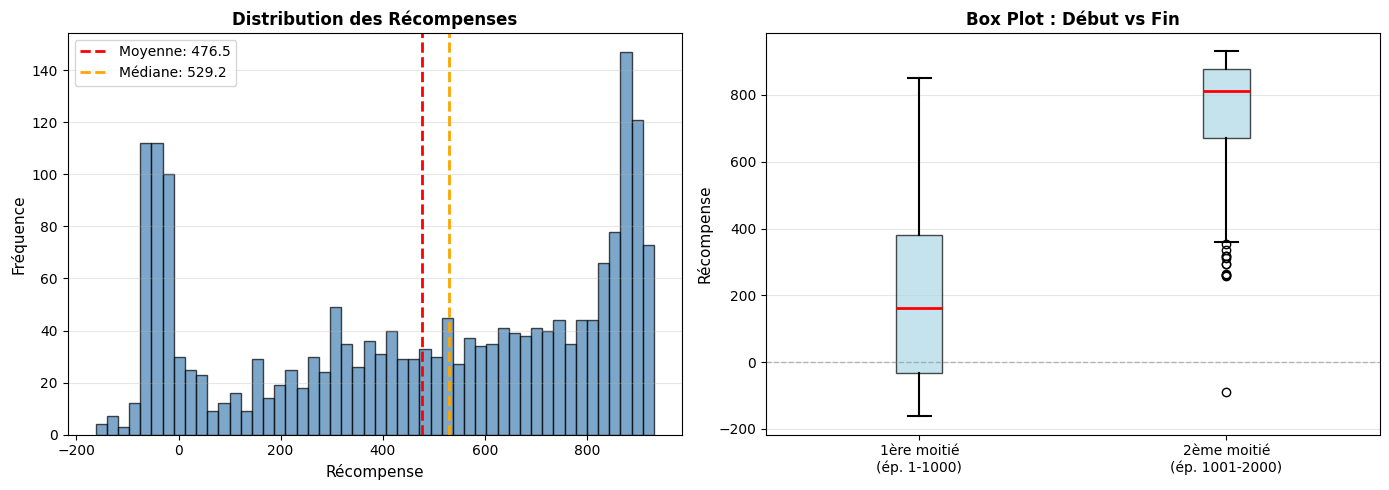


STATISTIQUES DE DISTRIBUTION
Moyenne       : 476.50
Médiane       : 529.20
Écart-type    : 344.73
Min           : -162.51
Q1 (25%)      : 161.09
Q3 (75%)      : 813.62
Max           : 931.30


In [16]:
# Distribution des récompenses
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogramme
ax1 = axes[0]
ax1.hist(df_T['reward'], bins=50, color='steelblue', alpha=0.7, edgecolor='black')
ax1.axvline(df_T['reward'].mean(), color='red', linestyle='--', linewidth=2, 
            label=f'Moyenne: {df_T["reward"].mean():.1f}')
ax1.axvline(df_T['reward'].median(), color='orange', linestyle='--', linewidth=2,
            label=f'Médiane: {df_T["reward"].median():.1f}')
ax1.set_xlabel('Récompense', fontsize=11)
ax1.set_ylabel('Fréquence', fontsize=11)
ax1.set_title('Distribution des Récompenses', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Box plot (début vs fin)
ax2 = axes[1]
box_data = [df_T['reward'].values]

if n_episodes >= 200:
    split_idx = n_episodes // 2
    first_half = df_T['reward'].iloc[:split_idx].values
    second_half = df_T['reward'].iloc[split_idx:].values
    box_data = [first_half, second_half]
    labels = [f'1ère moitié\n(ép. 1-{split_idx})', 
              f'2ème moitié\n(ép. {split_idx+1}-{n_episodes})']
else:
    labels = ['Tous les épisodes']

bp = ax2.boxplot(box_data, labels=labels, patch_artist=True,
                 boxprops=dict(facecolor='lightblue', alpha=0.7),
                 medianprops=dict(color='red', linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

ax2.set_ylabel('Récompense', fontsize=11)
ax2.set_title('Box Plot : Début vs Fin', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.5)

plt.tight_layout()
plt.show()

# Statistiques
print(f"\nSTATISTIQUES DE DISTRIBUTION")
print(f"{'='*70}")
print(f"Moyenne       : {df_T['reward'].mean():.2f}")
print(f"Médiane       : {df_T['reward'].median():.2f}")
print(f"Écart-type    : {df_T['reward'].std():.2f}")
print(f"Min           : {df_T['reward'].min():.2f}")
print(f"Q1 (25%)      : {df_T['reward'].quantile(0.25):.2f}")
print(f"Q3 (75%)      : {df_T['reward'].quantile(0.75):.2f}")
print(f"Max           : {df_T['reward'].max():.2f}")
print(f"{'='*70}")


COMPARAISON DE 3 MODÈLES


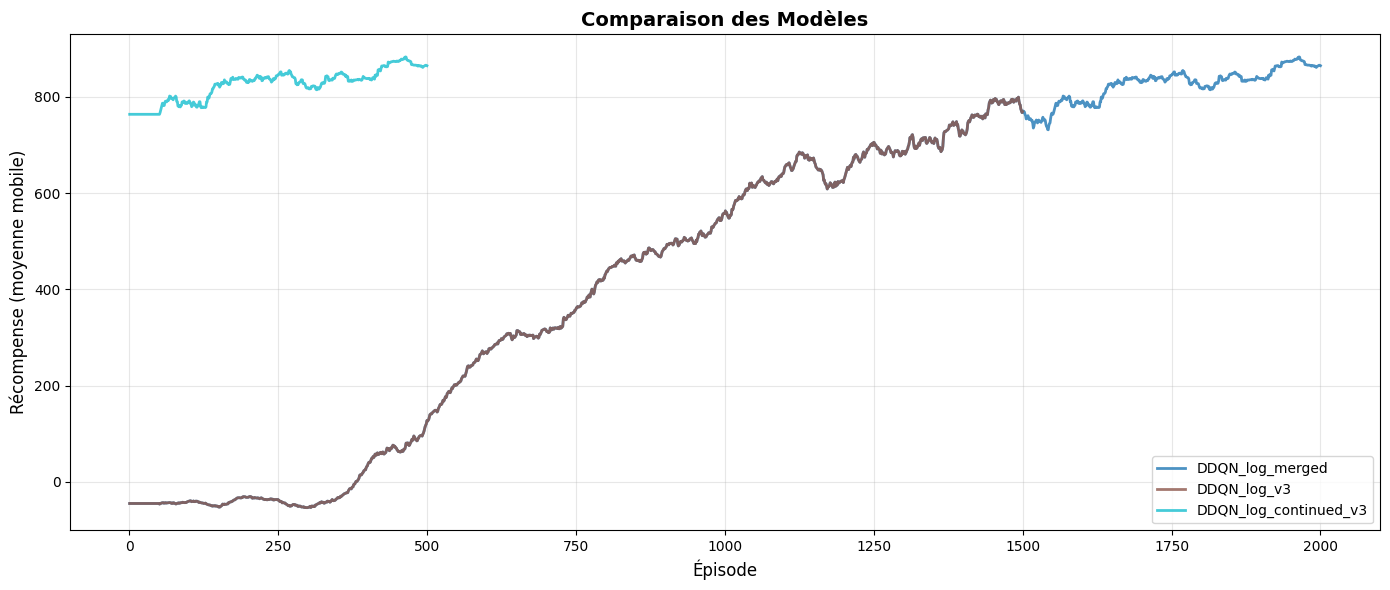


Modèle                                   Épisodes     Récompense Moy.      Max
DDQN_log_merged                          2000         476.50               931.30
DDQN_log_v3                              1500         358.73               919.80
DDQN_log_continued_v3                    500          829.83               931.30


In [17]:
# Comparaison multi-modèles (si plusieurs logs disponibles)
try:
    # Charger tous les logs
    all_logs = {}
    for log_file in log_files:
        log_name = log_file.split('/')[-1].replace('.csv', '')
        try:
            df_temp = pd.read_csv(log_file)
            df_temp_T = df_temp.T
            df_temp_T.columns = df_temp_T.iloc[0]
            df_temp_T = df_temp_T.drop(df_temp_T.index[0])
            df_temp_T = df_temp_T.reset_index(drop=True)
            df_temp_T['reward'] = pd.to_numeric(df_temp_T['reward'])
            all_logs[log_name] = df_temp_T['reward'].values
        except:
            pass
    
    if len(all_logs) > 1:
        print(f"\nCOMPARAISON DE {len(all_logs)} MODÈLES")
        print(f"{'='*70}")
        
        plt.figure(figsize=(14, 6))
        colors = plt.cm.tab10(np.linspace(0, 1, len(all_logs)))
        
        for (log_name, rewards), color in zip(all_logs.items(), colors):
            if len(rewards) >= 50:
                rewards_tensor = torch.tensor(rewards, dtype=torch.float)
                window = min(50, len(rewards))
                reward_f = torch.clone(rewards_tensor[:window])
                means = rewards_tensor.unfold(0, window, 1).mean(1).view(-1)
                means = torch.cat((torch.ones(window-1)*torch.mean(reward_f), means))
                plt.plot(range(1, len(rewards)+1), means.numpy(), 
                        label=log_name, linewidth=2, color=color, alpha=0.8)
            else:
                plt.plot(range(1, len(rewards)+1), rewards, 
                        label=log_name, linewidth=2, color=color, alpha=0.8)
        
        plt.xlabel('Épisode', fontsize=12)
        plt.ylabel('Récompense (moyenne mobile)', fontsize=12)
        plt.title('Comparaison des Modèles', fontsize=14, fontweight='bold')
        plt.legend(loc='best', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Tableau comparatif
        print(f"\n{'Modèle':<40} {'Épisodes':<12} {'Récompense Moy.':<20} {'Max'}")
        print(f"{'='*70}")
        for log_name, rewards in all_logs.items():
            print(f"{log_name:<40} {len(rewards):<12} {np.mean(rewards):<20.2f} {np.max(rewards):.2f}")
        print(f"{'='*70}")
        
    else:
        print("\nUn seul fichier de log trouvé.")
        
except Exception as e:
    print(f"\nErreur lors de la comparaison: {str(e)}")

## 8. Évaluation d'un Modèle DDQN Entraîné

### 8.1 Charger le Modèle en Mode Évaluation

**Mode 'eval' :**
- Epsilon = 0 (pas d'exploration, uniquement exploitation)
- Réseaux en mode évaluation (pas de dropout, etc.)
- Utilisé pour tester les performances réelles

In [ ]:
# Créer l'environnement avec rendu visuel
env = gym.make("CarRacing-v3", continuous=False, render_mode="human")
env = SkipFrame(env, skip=4)
env = gym_wrap.GrayscaleObservation(env)
env = gym_wrap.ResizeObservation(env, shape=(84, 84))
env = gym_wrap.FrameStackObservation(env, stack_size=4)
state, info = env.reset()
action_n = env.action_space.n

# Charger le modèle DDQN en mode évaluation
driver = Agent(
    state.shape,
    action_n,
    load_state='eval',            # Mode 'eval' (epsilon=0)
    load_model='DDQN_495213.pt',  # Modifier selon votre fichier
    double_q=True                 # DDQN
)

print(f"Modèle chargé en mode évaluation")
print(f"Epsilon: {driver.epsilon}")
print(f"Algorithme: {'DDQN' if driver.double_q else 'DQN'}")

✅ Modèle DDQN chargé en mode évaluation
Epsilon: 0 (0% exploration)
Algorithme: DDQN


### 8.2 Exécuter les Épisodes d'Évaluation

In [ ]:
# Paramètres d'évaluation
episodes = 10
scores_array = []
timestep_arr = []
seeds_list = [i for i in range(10, 20, 1)]

print(f"Début de l'évaluation sur {episodes} épisodes...\n")

for episode, sd in enumerate(seeds_list):
    state, info = env.reset(seed=sd)
    updating = True
    score = 0
    timestep = 0
    
    while updating:
        action = driver.take_action(state) 
        state, reward, terminated, truncated, info = env.step(action)
        updating = not (terminated or truncated)
        score += reward
        timestep += 1
        
    scores_array.append(score)
    timestep_arr.append(timestep)
    print(f"Episode {episode+1}, Score: {score:.2f}, Timesteps: {timestep}")

env.close()

# Statistiques finales
mean_score = np.mean(scores_array)
std_score = np.std(scores_array)
mean_timesteps = np.mean(timestep_arr)

print(f"\n{'='*50}")
print(f"Résultats:")
print(f"Score moyen: {mean_score:.2f} ± {std_score:.2f}")
print(f"Timesteps moyens: {mean_timesteps:.2f}")
print(f"Meilleur score: {max(scores_array):.2f}")
print(f"Pire score: {min(scores_array):.2f}")
print(f"{'='*50}")

Début de l'évaluation sur 10 épisodes...

Episode 1, Score: 843.52, Timesteps: 250
Episode 1, Score: 843.52, Timesteps: 250


KeyboardInterrupt: 